## setup

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/2025-06-15_216_tprocv2r24_standard/qick_216.bit')
soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.353

Firmware configuration (built Sun Jun 15 17:47:17 2025):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc core clock, tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 65536 complex samples (6.838 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 32768 complex samples (3.419 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samp

## Randomized Benchmarking
RB sequence generator: based on https://github.com/openquantumhardware/devForLBNL/blob/master/RB_code_demo/20220201-3DTransmon-Chacracterization%2BRB.ipynb


In [3]:
"""Writing the sequences in terms of Clifford group algebra
    The Clifford gate set forms a closed group => 
    1. Multiplication of any two gates results in a gate part of the group 
    2. Each gate has an inverse
    3. The inverse of a product of multiple Clifford gates is unique
"""
import random
from qick.tprocv2_assembler import LFSR

def generate_rbsequence(depth, use_lfsr=False, lfsr_seed=0):
    
    """Single qubit RB program to generate a sequence of 'd' gates followed 
        by an inverse gate to bring the qubit back in 'g' state
    """

    gate_symbol = ['I', 'Z', 'X', 'Y', 'Z/2', 'X/2', 'Y/2', '-Z/2', '-X/2', '-Y/2']
    inverse_gate_symbol = ['I', '-Y/2', 'X/2', 'X', 'Y/2', '-X/2']

    """Modeled the bloch sphere as 6-node graph, each rotation in the RB sequence is effectively
    exchanging the node label on the bloch sphere.
    For example: Z rotation is doing this: (+Z->+Z, -Z->-Z, +X->+Y, +Y->-X, -X->-Y, -Y->+X)
    """
    """Matrix columns are [Z, X, Y, -Z, -X, -Y]"""
    gates_dict ={
                'I'    : np.matrix([[1, 0, 0, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0],
                                     [0, 0, 0, 1, 0, 0],
                                     [0, 0, 0, 0, 1, 0],
                                     [0, 0, 0, 0, 0, 1]]
                                    ),
                'Z'    : np.matrix([[1, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 1, 0],
                                     [0, 0, 0, 0, 0, 1],
                                     [0, 0, 0, 1, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0]]
                                    ),
                'X'    : np.matrix([[0, 0, 0, 1, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 1],
                                     [1, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 1, 0],
                                     [0, 0, 1, 0, 0, 0]]
                                    ),
                'Y'    : np.matrix([[0, 0, 0, 1, 0, 0],
                                     [0, 0, 0, 0, 1, 0],
                                     [0, 0, 1, 0, 0, 0],
                                     [1, 0, 0, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 1]]
                                    ),
                'Z/2'  : np.matrix([[1, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 1],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 0, 1, 0, 0],
                                     [0, 0, 1, 0, 0, 0],
                                     [0, 0, 0, 0, 1, 0]]
                                    ),
                'X/2'  : np.matrix([[0, 0, 1, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 0, 1, 0, 0],
                                     [0, 0, 0, 0, 0, 1],
                                     [0, 0, 0, 0, 1, 0],
                                     [1, 0, 0, 0, 0, 0]]
                                    ),
                'Y/2'  : np.matrix([[0, 0, 0, 0, 1, 0],
                                     [1, 0, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 0, 1, 0, 0],
                                     [0, 0, 0, 0, 0, 1]]
                                    ),
                '-Z/2' : np.matrix([[1, 0, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0],
                                     [0, 0, 0, 0, 1, 0],
                                     [0, 0, 0, 1, 0, 0],
                                     [0, 0, 0, 0, 0, 1],
                                     [0, 1, 0, 0, 0, 0]]
                                     ),
                '-X/2' : np.matrix([[0, 0, 0, 0, 0, 1],
                                     [0, 1, 0, 0, 0, 0],
                                     [1, 0, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0],
                                     [0, 0, 0, 0, 1, 0],
                                     [0, 0, 0, 1, 0, 0]]
                                     ),
                '-Y/2' : np.matrix([[0, 1, 0, 0, 0, 0],
                                     [0, 0, 0, 1, 0, 0],
                                     [0, 0, 1, 0, 0, 0],
                                     [0, 0, 0, 0, 1, 0],
                                     [1, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 1]]
                                     )
    }
    
    # Generate a random gate sequence of a certain depth 'd'
    gates_set_size = len(gates_dict)
    gate_seq_idx = []
    gate_seq = []
    if not use_lfsr:
        gate_seq_idx = np.random.randint(0,gates_set_size,depth)
    else:
        lfsr_gen = LFSR()
        lfsr_gen.seed(lfsr_seed)
        idx = lfsr_seed & 0xF
        for ii in range(depth):
            while (idx > gates_set_size-1):
                idx = lfsr_gen.nxt() & 0xF
                # lfsr_gen.print(debug=True)
            gate_seq_idx.append(idx)
            idx = gates_set_size
        # print(gate_seq_idx)
    # Map indexes to gates symbol
    gate_seq = [list(gates_dict)[i] for i in gate_seq_idx]

    # Initial node
    a0 = np.matrix([[1], [0], [0], [0], [0], [0]])
    # print('State Initial: ',a0.T)
    anow = a0
    for ii, gate_symbol in enumerate(gate_seq):
        anow = np.dot(gates_dict.get(gate_symbol), anow)
        # print('State',ii+1,':',anow.T)

    # Get the recover gate
    gate_inverse = inverse_gate_symbol[list(anow).index(max(anow))]
    gate_seq.append(gate_inverse)

    # Calculate final state for check
    anow = np.dot(gates_dict.get(gate_inverse), anow)
    # print('State Final:',anow.T)

    return gate_seq

A = generate_rbsequence(10, False)
print(A)
B = generate_rbsequence(10, True, lfsr_seed=0)
print(B)
C = generate_rbsequence(10, True, lfsr_seed=123456789)
print(C)


['Z/2', 'Z/2', 'Z/2', 'X', 'X/2', 'Z', '-Z/2', 'X/2', '-Y/2', 'X', 'I']
['I', 'Z', 'X', 'Z/2', '-Y/2', 'X', 'Z/2', '-Y/2', 'X', 'Z/2', '-Y/2']
['X/2', 'X/2', '-Z/2', '-Y/2', 'X', 'Z/2', '-X/2', 'I', 'Z', 'Y', 'I']


In [4]:
from qick.asm_v2 import AveragerProgramV2, AsmV2, AsmInst

class RBSequenceProgram(AveragerProgramV2):

    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']

        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.gate_set = cfg['gate_set']
        self.gate_seq = generate_rbsequence(depth=cfg['gates_seq_len'], use_lfsr=cfg['use_lfsr'], lfsr_seed=cfg['lfsr_seed'])

        # Generate minimum length pulses
        gauss_len = self.cycles2us(3, gen_ch=gen_ch)
        self.add_gauss(ch=gen_ch, name="gauss_env", sigma=gauss_len/10, length=gauss_len, even_length=False)
    
        """This adds the different types of pulses to the pulse library which can be played on demand later"""
        for gate_symbol, ginfo in self.gate_set.items():
            self.add_pulse(ch=gen_ch, name=gate_symbol,
                            style=      ginfo["style"],
                            envelope=   ginfo["envelope"],
                            freq=       ginfo["freq"],
                            phase=      ginfo["phase"],
                            gain=       ginfo["gain"],
                          )

        self.add_pulse(ch=gen_ch, name="const_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=0.2,
                      )

        # # Subroutine to modify the phase of the WaveForm Table
        # sub_virt_z = AsmV2()
        # for gname, ginfo in self.gate_set.items():
        #     for wname in self.list_pulse_waveforms(gname):
        #         sub_virt_z.read_wmem(name=wname)
        #         sub_virt_z.inc_reg(dst='w_phase', src=self.deg2reg(180, gen_ch=cfg['gen_ch']))
        #         sub_virt_z.write_wmem(name=wname)
        # self.add_subroutine("virt_z", sub_virt_z)

        # Subroutine to generate random sequence using LFSR
        sub_gen_rnd_seq = AsmV2()
        if sub_gen_rnd_seq:
            # Initialize Seed of LFSR (write s1 with seed literal)
            sub_gen_rnd_seq.write_reg(dst='s1', src='r1')
            sub_gen_rnd_seq.label('gen_seq_loop')
            # Read LFSR
            sub_gen_rnd_seq.write_reg(dst='r3', src='s1')
            ## Take 4 lsbs
            inst = AsmInst(inst={'CMD':"REG_WR", 'DST': 'r4', 'SRC':'op', 'OP': 'r3 AND #15'}, addr_inc=1)
            sub_gen_rnd_seq.append_macro(inst)
            ## Check if index is within Set Range (r4 - set_size < 0)
            sub_gen_rnd_seq.cond_jump(label='gen_seq_loop', arg1='r4', test='NS', op='-', arg2=10)
            # Write Wave Port with LFSR index
            inst = AsmInst(inst={'CMD':"WPORT_WR", 'DST': '0', 'SRC':'wmem', 'ADDR': 'r4'}, addr_inc=1)
            sub_gen_rnd_seq.append_macro(inst)
            # Repeat L times
            sub_gen_rnd_seq.inc_reg(dst='r2', src=-1)
            sub_gen_rnd_seq.cond_jump(label='gen_seq_loop', arg1='r2', test='NZ', op='-', arg2=0)
            self.add_subroutine("gen_rnd_seq", sub_gen_rnd_seq)

        # Configure Readout
        self.add_readoutconfig(ch=ro_ch, name="measure", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="measure", t=0)


    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        # self.delay(0.5)
        
        print(self.gate_seq)
        if not cfg['use_lfsr']:
            self.phase_ref = 0
            for gate in self.gate_seq:
                ginfo = self.cfg["gate_set"][gate]
                """For the Z gates (virtual rotation), we need to advance the phase of all the pulses which follows afterwards"""
                if gate == "Z":
                    self.phase_ref += 180
                    # self.call("virt_z")
                elif gate == "Z/2":
                    self.phase_ref += 90
                    # self.call("virt_z_ov_2")
                elif gate == "-Z/2":
                    self.phase_ref += -90
                    # self.call("virt_z_ov_2")
                else:
                    # self.pulse(ch=self.cfg["qubit_ch"], name=gate, phase=deg2reg(self.phase_ref+ginfo["phase"]), gain=ginfo["gain"], play=True)
                    # self.pulse(ch=self.cfg["gen_ch"], name=gate, phase=ginfo["phase"]+self.phase_ref, gain=ginfo["gain"])
                    # self.pulse(ch=self.cfg["gen_ch"], name=gate, t='auto')
                    pass
                # Execute always even if Z gate to see the same number of pulses as gates
                self.pulse(ch=self.cfg["gen_ch"], name=gate, t='auto')
        else:
            # Configure LFSR seed in r1
            self.write_reg(dst='r1', src=cfg['lfsr_seed'])
            # Configure Random Sequence Length in r2
            self.write_reg(dst='r2', src=cfg['gates_seq_len'])
            # Generate Random Sequence
            self.call("gen_rnd_seq")
            # Add last gate
            gate = self.gate_seq[-1]
            self.pulse(ch=self.cfg["gen_ch"], name=gate, t='auto')

        # self.delay(0.5)
        self.pulse(ch=self.cfg["gen_ch"], name='const_pulse', t=1.0)


['X/2', 'X/2', '-Z/2', '-Y/2', 'X', 'Z/2', '-X/2', 'I', 'Z', 'Y', 'Y/2', 'Y/2', '-Y/2', 'Y', 'Y/2', '-Y/2', 'X', 'X/2', '-Z/2', '-Z/2', '-Y/2', 'X', 'X/2', 'Y/2', 'X/2', 'I']


  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 0, 'us')

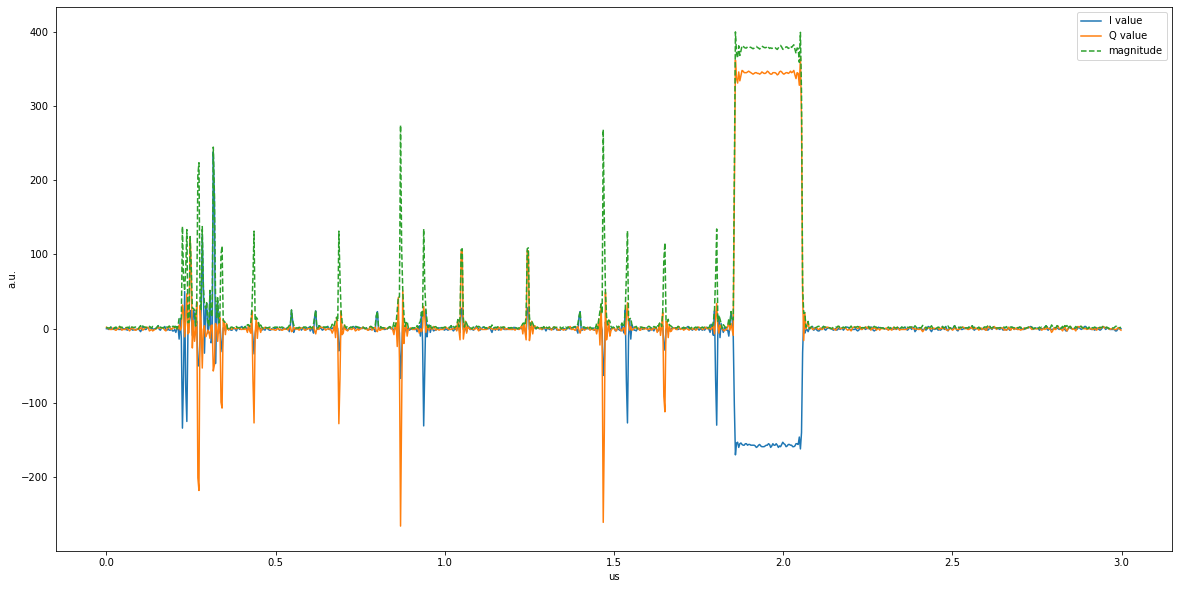

In [5]:
GEN_CH = 0
RO_CH = 0
GATES_SEQ_LEN = 25
TRIG_TIME = 0.2
FREQ = 500
RO_LEN = 3.0
USE_LFSR = True
LFSR_SEED = 123456789

qubit_params = {'pi_gain': 1.0, 'pi_2_gain': 0.5, 'freq': FREQ}

# Configure tProc LFSR to step on s1 read
soc.tproc.set_lfsr_cfg(2)

rb_config = {
        #     'qubit_freq': nu_q_new, 'qubit_ch': 0, 
        #     'rr_freq': f_res + 0.180, 'rr_ch': 0 , 'rr_length': us2cycles(3), 'rr_gain': 10000,
        #     'rr_phase': deg2reg(rot_angle), "adc_trig_offset": 250, 'beta':0,
                'gen_ch': GEN_CH,
                'ro_ch': RO_CH,
                'ro_len': RO_LEN,
                'freq': qubit_params['freq'],
                'trig_time': TRIG_TIME,
                'relax_delay':500,
                'reps':10, 'rounds':0,
                'use_lfsr': USE_LFSR,
                'lfsr_seed': 123456789,
                # 'gate_seq': generate_rbsequence(GATES_SEQ_LEN, lfsr=False),
                # 'gate_seq': generate_rbsequence(GATES_SEQ_LEN, lfsr=LFSR, lfsr_seed=LFSR_SEED),
                # 'gate_seq': ['I','X','Y','Z','-X/2','-X/2','Z/2','Y/2'],
                'gates_seq_len': GATES_SEQ_LEN,
                'gate_set':{
                        "I": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         0.1, 
                                },
                        "X": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":qubit_params['pi_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['pi_gain'], 
                                },
                        "Y": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "phase":-90, "gain":qubit_params['pi_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        -90, 
                                "gain":         qubit_params['pi_gain'], 
                                },
                        "Z": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         0.1, 
                                },
                        "X/2": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['pi_2_gain'], 
                                },
                        "-X/2": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":180, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        180, 
                                "gain":         qubit_params['pi_2_gain'], 
                                },
                        "Y/2": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":-90, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        -90, 
                                "gain":         qubit_params['pi_2_gain'], 
                                },
                        "-Y/2": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":90, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        90, 
                                "gain":         qubit_params['pi_2_gain'], 
                                },
                        "Z/2": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         0.1, 
                                },
                        "-Z/2": {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         0.1, 
                                },
                        } 
               }

prog = RBSequenceProgram(soccfg, reps=1, final_delay=0.33, cfg=rb_config)

iq_list = prog.acquire_decimated(soc, rounds=1)
t = prog.get_time_axis(ro_index=0)

plt.figure(figsize=[20,10])
# plt.subplot(2,1,1)
plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
# plt.subplot(2,1,2)
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude", ls='--')
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")


In [6]:
# print the program - ugly!
print(prog)

prog.print_pmem2hex()
prog.print_wmem2hex()

prog.print_sg_mem(sg_idx=0, gen_file=True)


macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='measure', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff57e18e20>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff57e18d90>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	Trigger(ros=[0], pins=[0], t=0.2, width=0.023251488095238096, ddr4=True, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff57e1b5e0>, 'width': <qick.asm_v2.QickParam object at 0xffff57e18dc0>}, t_regs={'t': 86, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 9, 10})
	WriteReg(dst='r1', src=123456789)
	WriteReg(dst='r2', src=25)
	AsmInst(inst={'CMD': 'CALL', 'LABEL': 'gen_rnd_seq'}, addr_inc=1)
	Pulse(ch=0, name='I', t='auto', tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff57e19510>}, t_regs={'t': 0})
	Pulse(ch=0, name='const_pulse', t=1.0, tag=None, t_params={'t': <qick.asm_v2.QickParam 